## Conformal Prediction Intervals

This notebook walks through computing a very simple prediction interval using conformal predictions. This is intended as a toy example to learn how this works.  Typical applications will use a more sophisticated methodology along with existing implementations found within the resources below.


#### Resources:

1. Quick intro to conformal prediction in [medium](https://towardsdatascience.com/mapie-explained-exactly-how-you-wished-someone-explained-to-you-78fb8ce81ff3)

2. Gentle Introduction to Conformal Prediction and
Distribution-Free Uncertainty Quantification, [paper link](https://people.eecs.berkeley.edu/~angelopoulos/publications/downloads/gentle_intro_conformal_dfuq.pdf)

3. Conformal Prediction repos: [Awesome Conformal Prediction](https://github.com/valeman/awesome-conformal-prediction)


In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [4]:
# Replace this with your Google Drive link
shared_link = "https://drive.google.com/file/d/1SXHcqZ8bvCtG2ASjKNjJYjQ3P_b8eXOm/view?usp=share_link"

# Convert the shared link to a direct download link
file_id = shared_link.split("/d/")[1].split("/view")[0]
direct_link = f"https://drive.google.com/uc?id={file_id}"

# Load the data into a DataFrame
data = pd.read_csv(direct_link)

# Display the first few rows of the data
data.head()


,price,year_sold,property_tax,insurance,beds,baths,sqft,year_built,lot_size,basement,popular,recession,property_age,property_type_Bunglow,property_type_Condo
0,295850,2013,234,81,1,1,584,2013,0,0,0,1,0,0,1
1,216500,2006,169,51,1,1,612,1965,0,1,0,0,41,0,1
2,279900,2012,216,74,1,1,615,1963,0,0,0,1,49,0,1
3,379900,2005,265,92,1,1,618,2000,33541,0,0,0,5,0,1
4,340000,2002,88,30,1,1,634,1992,0,0,0,0,10,0,1


In [30]:
data = pd.read_csv('housing_data.csv')
data.head()

,price,year_sold,property_tax,insurance,beds,baths,sqft,year_built,lot_size,basement,popular,recession,property_age,property_type_Bunglow,property_type_Condo
0,295850,2013,234,81,1,1,584,2013,0,0,0,1,0,0,1
1,216500,2006,169,51,1,1,612,1965,0,1,0,0,41,0,1
2,279900,2012,216,74,1,1,615,1963,0,0,0,1,49,0,1
3,379900,2005,265,92,1,1,618,2000,33541,0,0,0,5,0,1
4,340000,2002,88,30,1,1,634,1992,0,0,0,0,10,0,1


#### Create dummies and split the data

Train and test set

In [31]:
x = data.drop('price', axis=1)
y = data.price
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.02)

#### 1. Fit model on training data

In [32]:
model = RandomForestRegressor().fit(x_train, y_train)

#### 2. Make prediction on the test data used to identify the prediction interval

In [33]:
y_test_pred = model.predict(x_test)

#### 3. Examine Prediction Errors

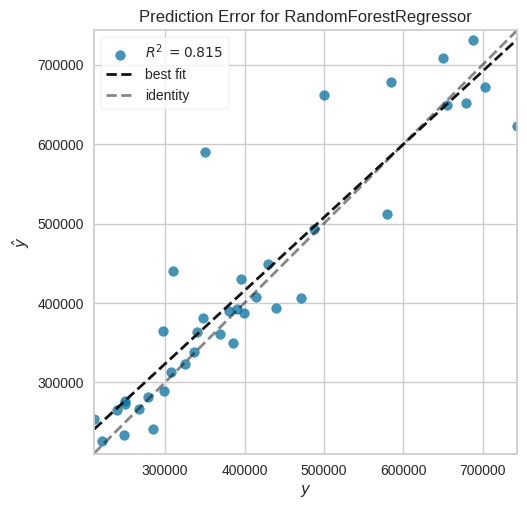

<Axes: title={'center': 'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [34]:
from yellowbrick.regressor import PredictionError
visualizer = PredictionError(model)
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

How to read the above chart:

The data point (y) = ~600000 was predicted as (yhat) ~500000

Compute absolute errors made by the model on calibration data

In [36]:
y_test_error = np.abs(y_test - y_test_pred)

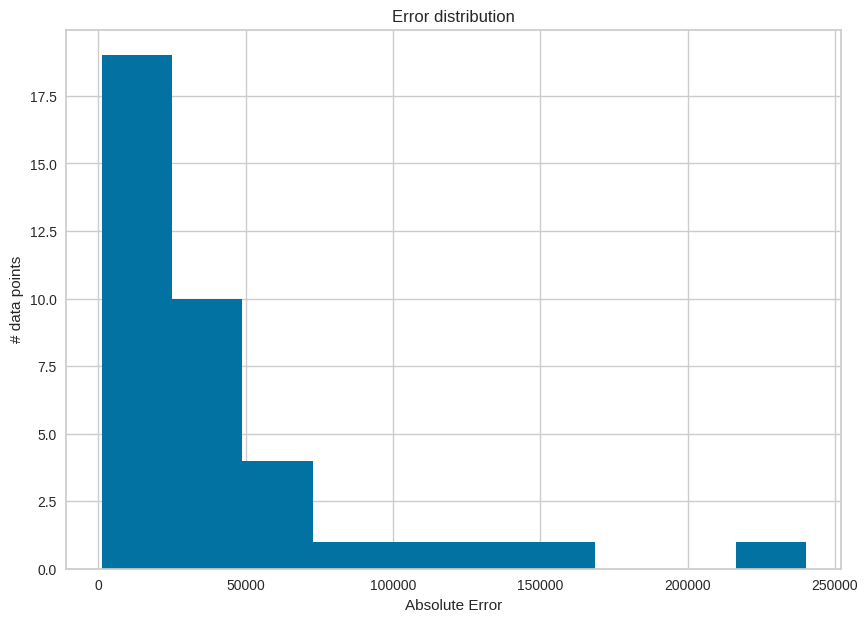

In [37]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_test_error)
plt.xlabel("Absolute Error")
plt.ylabel("# data points")
plt.title("Error distribution")
# Show plot
plt.show()

You will see that most of the absolute errors are close to 0 and range between 0 and 60,000

#### 4. Get the quantile from the distribution of absolute errors

The quantile method finds the 95th percentile of the error distribution to define the range of uncertainty.

In [38]:
quantile = y_test_error.quantile(q=.95, interpolation='higher')
quantile

161729.63

 Imagine you have a big pile of candy, and each candy is a little different in size. You want to figure out how big most of the candies are, but you also want to ignore the really big or really small ones that don’t happen often.

So, you line up all the candies from smallest to biggest. Then, you pick the candy that's bigger than 95% of the others. This candy size is your 95th percentile. It tells you how big the candy is if you want to cover almost all candies but leave out the super rare, extra-big ones.

Let's visualize this on the histogram

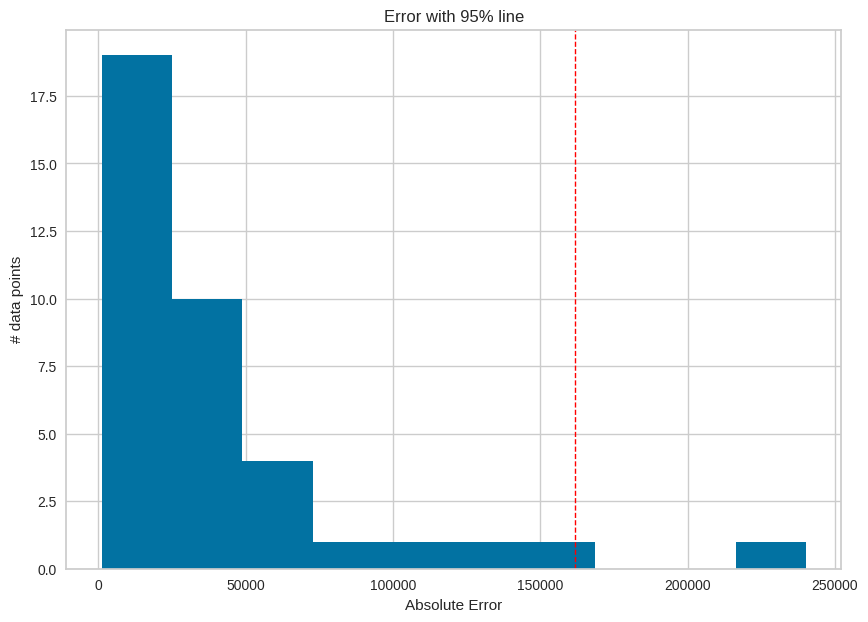

In [39]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_test_error)
plt.axvline(quantile, color='red', linestyle='dashed', linewidth=1)
plt.xlabel("Absolute Error")
plt.ylabel("# data points")
plt.title("Error with 95% line")
# Show plot

# Show plot
plt.show()

#### 6. Compute intervals by either subtracting or adding the quantile to the predictions

In [40]:
y_test_interval_pred_left = y_test_pred - quantile
y_test_interval_pred_right = y_test_pred + quantile

In [41]:
df = pd.DataFrame(list(zip(y_test,y_test_pred,y_test_interval_pred_left,y_test_interval_pred_right)),
                  columns=['actual','predicted','lower_interval','upper_interval'])
df


,actual,predicted,lower_interval,upper_interval
0,486990,493009.82,331280.19,654739.45
1,336000,337541.20,175811.57,499270.83
2,649415,708843.58,547113.95,870573.21
3,679370,652188.29,490458.66,813917.92
4,415000,407250.20,245520.57,568979.83
5,279000,281692.81,119963.18,443422.44
6,210000,253285.58,91555.95,415015.21
7,470630,405689.25,243959.62,567418.88
8,299000,289209.18,127479.55,450938.81
9,743500,623330.90,461601.27,785060.53


In [42]:
df1 = df.sample(n=8, replace=True, random_state=15)

Plot a few intervals

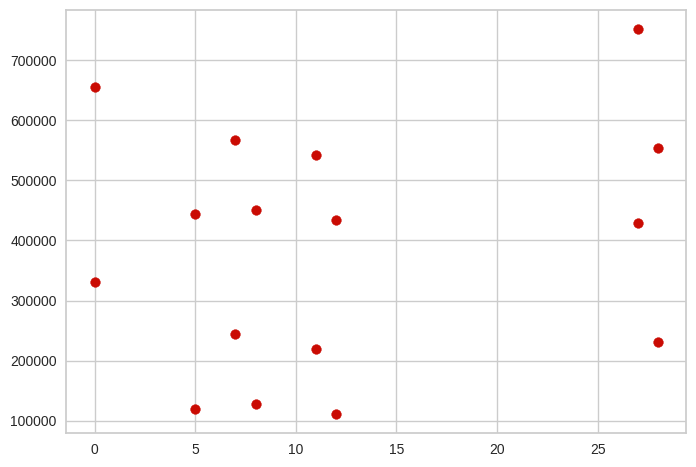

In [43]:

plt.scatter(x=df1.index,y=df1['lower_interval'], color = 'r')
plt.scatter(x=df1.index,y=df1['upper_interval'], color = 'r')
plt.show()

Adding the actual values

See one example on the far right, where the actual was outside of the prediction interval

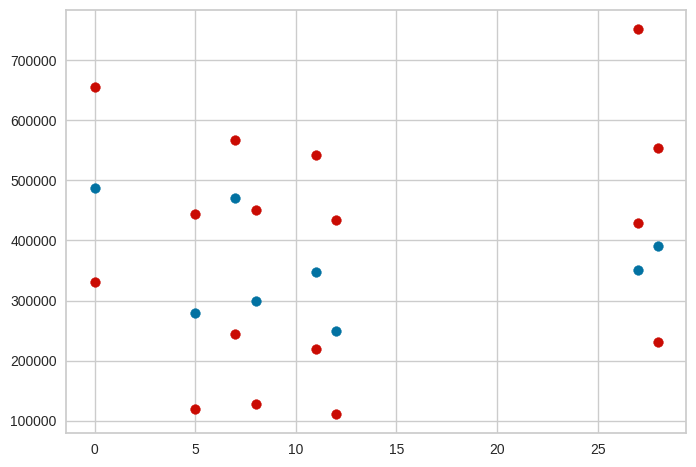

In [44]:
plt.scatter(x=df1.index, y= df1['actual'])
plt.scatter(x=df1.index,y=df1['lower_interval'], color = 'r')
plt.scatter(x=df1.index,y=df1['upper_interval'], color = 'r')
plt.show()

Most of the actuals are between the prediction intervals, only the second from the last is out of bounds.